In [1]:
import os
import glob

import numpy as np

import matplotlib.pyplot as plt

import struct

import pandas as pd

In [2]:
'''
Os arquivos .pcap foram formados com o comando
 > tcpdump ...
enquanto a Skarab funcionava com algum firmware.
'''

pcapfiles=sorted(glob.glob('*.pcap'))
print(len(pcapfiles),pcapfiles)

12 ['zteste1.pcap', 'zteste2.pcap', 'zteste3.pcap', 'zteste4.pcap', 'zteste5.pcap', 'zteste6.pcap', 'zteste7.pcap', 'zteste_2can_fc120_bw128.pcap', 'zteste_2can_fc120_bw128_2.pcap', 'zteste_2canais_fc110.pcap', 'zteste_2canais_fc110_2.pcap', 'zteste_2canais_fc110_3.pcap']


In [4]:
#escolher um arquivo da lista acima e abir-lo (ou seja, colocar no buffer) como um arquivo binário para leitura (opção 'rb')
num=10
esse=pcapfiles[10]
print(esse)
with open(esse,'rb') as f:
    mybuff=f.read()

zteste_2canais_fc110_2.pcap


In [5]:
#mostrar tamanho em bytes (8 bits)
len(mybuff)
#mostrar em formato binário (scary!) 
print(mybuff[:60])
#mostrar em formato hexdecimal (less scary!)
print(mybuff[:60].hex())

b'\xd4\xc3\xb2\xa1\x02\x00\x04\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x04\x00\x01\x00\x00\x00?\xed\xb0g\x1a3\n\x00\x8a \x00\x00\x8a \x00\x00\x1c\xfd\x08}X\x99\x06P\x02\x0f\x03\x01\x08\x00E\x00 |\x00\x00'
d4c3b2a102000400000000000000000000000400010000003fedb0671a330a008a2000008a2000001cfd087d58990650020f030108004500207c0000


In [6]:
"""
Transformar em um np.array formado de int8 o array acima para manter a quantidade de números.
Isso vai ajudar a manipular o array com os métodos do numpy
Removemos os 24 primeiros elementos, pois é uma espécie de header geral. 
O procedimento será ir descobrindo o que é header geral (comparando com o output do wireshark),
e depois ver o que é header e dados em cada header
"""

dt = np.dtype('int8')
coisa_int8=np.frombuffer(mybuff,dt)
newcoisa_int8=coisa_int8[24:]
print(newcoisa_int8.shape)
newcoisa_int8[:100].data.hex()

(83460000,)


'3fedb0671a330a008a2000008a2000001cfd087d58990650020f030108004500207c00004000ff11513b0a2a000c000000002710000020680000530402060000000b800100000005addf8002000000080000800300000000000080040000000020009011'

In [7]:
# fazer um reshape com 8346 e o que sobre é o número de frames.
# Controlamos o número de frames com o flag -c no tcpdump
nn_re=newcoisa_int8.reshape(-1,8346)
print(nn_re.shape)
print(nn_re)
# notar que as colunas iniciais são iguais, implicando algum tipo de header (iguais) de cada frame

(10000, 8346)
[[ 63 -19 -80 ...  -3   0   0]
 [ 63 -19 -80 ...   1   0   2]
 [ 63 -19 -80 ...   0  -1  -3]
 ...
 [ 64 -19 -80 ...   3   0   1]
 [ 64 -19 -80 ...   3  -1  -2]
 [ 64 -19 -80 ...  -2  -1  -1]]


In [8]:
# retira um header antes dos dados do UDP...o pacote UDP tem 8330 bytes (ou int8) de acordo com o wireshark 
# Daí tem uma parte para ser removida até 2888 e por fim dados mesmo são 8192. 
# Portanto será preciso remover ainda 8330-8192=138 elementos no início de cada frame
new_re=nn_re[:,16:] 
print(new_re.shape)
print(new_re[:10,:10])
print(new_re.flatten()[:148].data.hex())

(10000, 8330)
[[  28   -3    8  125   88 -103    6   80    2   15]
 [  28   -3    8  125   88 -103    6   80    2   15]
 [  28   -3    8  125   88 -103    6   80    2   15]
 [  28   -3    8  125   88 -103    6   80    2   15]
 [  28   -3    8  125   88 -103    6   80    2   15]
 [  28   -3    8  125   88 -103    6   80    2   15]
 [  28   -3    8  125   88 -103    6   80    2   15]
 [  28   -3    8  125   88 -103    6   80    2   15]
 [  28   -3    8  125   88 -103    6   80    2   15]
 [  28   -3    8  125   88 -103    6   80    2   15]]
1cfd087d58990650020f030108004500207c00004000ff11513b0a2a000c000000002710000020680000530402060000000b800100000005addf80020000000800008003000000000000800400000000200090110000068e778090150000000005969009000000008000904600000a6e49c090270000000000279600000004e95b8b1800000000000000ff5b0043fffc0000ffcc


In [9]:
final_re=new_re[:,138:]
print(final_re.shape)
print(final_re[:10,:10])
print(final_re.flatten()[:10].data.hex())

(10000, 8192)
[[  -1   91    0   67   -1   -4    0    0   -1  -52]
 [  -1  -87    0   20    0    1    0    4   -1  -71]
 [   0   17   -1  -41   -1   -7    0    2    0   97]
 [   0   83   -1  -15    0    2    0    3    0   66]
 [  -1 -108   -1  -63   -1   -2    0    0    0   70]
 [   0   20    0   82   -1   -4    0    3   -1  -17]
 [   0   15    0   56    0    1   -1   -1    0   46]
 [   0   24   -1 -108    0    0    0    0    0   74]
 [  -1  -85   -1  -83   -1   -3   -1   -3   -1  -70]
 [   0   16   -1 -117    0    3    0    3    0   51]]
ff5b0043fffc0000ffcc


In [10]:
te1=final_re.reshape(-1)  # pode ser usado o método .flatten().
print(te1.shape)
print(te1[:10])

# As linhas abaixo é para fazer um check de comparação se o reshape(-1) ou .flatten funciona direito
#te3=te1.reshape(-1,8192)  #just to test and check with final_re
#print(te3.shape)
#te3[:10,:10]

(81920000,)
[ -1  91   0  67  -1  -4   0   0  -1 -52]


In [11]:
# Voltar para bytes
te1_bytes=te1.tobytes()

# caso queira ver em hex.
#te1_hex=te1.data.hex()
#print(te1_hex[:50])


In [12]:
# os dados estão codificados em int16. Agora é para valer:

dt = np.dtype('int16')
coisa=np.frombuffer(te1_bytes,dt)
print(coisa.shape)

(40960000,)


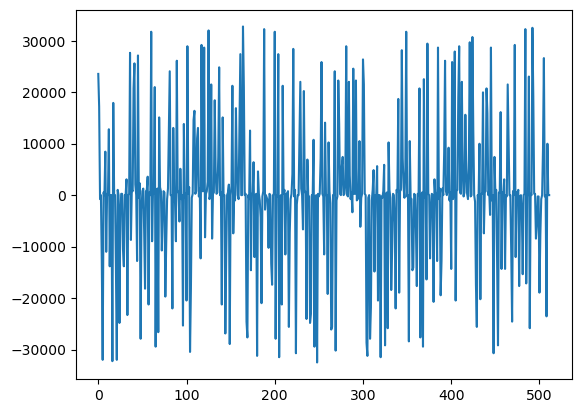

In [13]:
#Plotando uma amostra. Não vai fazer sentido. Tem que separar ainda os dados.
plt.plot(coisa[:512])

In [18]:
# Separando. Há duas entradas pela skarab sendo lendo, a entrada 0, in0, e a entrada 1, in1; 
# Em cada entrada, tem-se os dados em I/Q, ou seja, parte real e parte imaginária;
# A cada 4 elementos, tem-se na sequência in0_im, in0_re, in1_im, in1_re

in0_im=coisa[::4]
in0_re=coisa[1::4]
in1_im=coisa[2::4]
in1_re=coisa[3::4]

# para o futuro, já fazemos a combinação dos sinais em um único número complexo
in0_c = in0_re+1j*in0_im
in1_c= in1_re+1j*in1_im

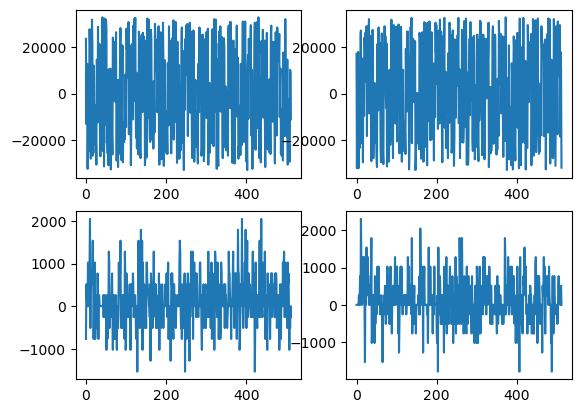

In [17]:
#plotando uma pequena amostra de cada componente. Difícil de entender e visualizar
kk=512
fig,ax=plt.subplots(2,2)
ax[0,0].plot(in0_im[:kk])
ax[0,1].plot(in0_re[:kk])
ax[1,0].plot(in1_im[:kk])
ax[1,1].plot(in1_re[:kk])

In [30]:
#Fazendo os waterfall (espectrograma) para analisar os dados melhor

# Definir o sampling rate efetivo, ou seja, sampling rate real que foi selecionado dividido pela decimação selecionada, 
# por exemplo, 2048 MHz/128=16 MHz, que vai ser a bandwidth
# Definir o número de canais nfft
# Definir a frequência central selecionada
fs1=16*1e6
nfft=512
fc=110e6


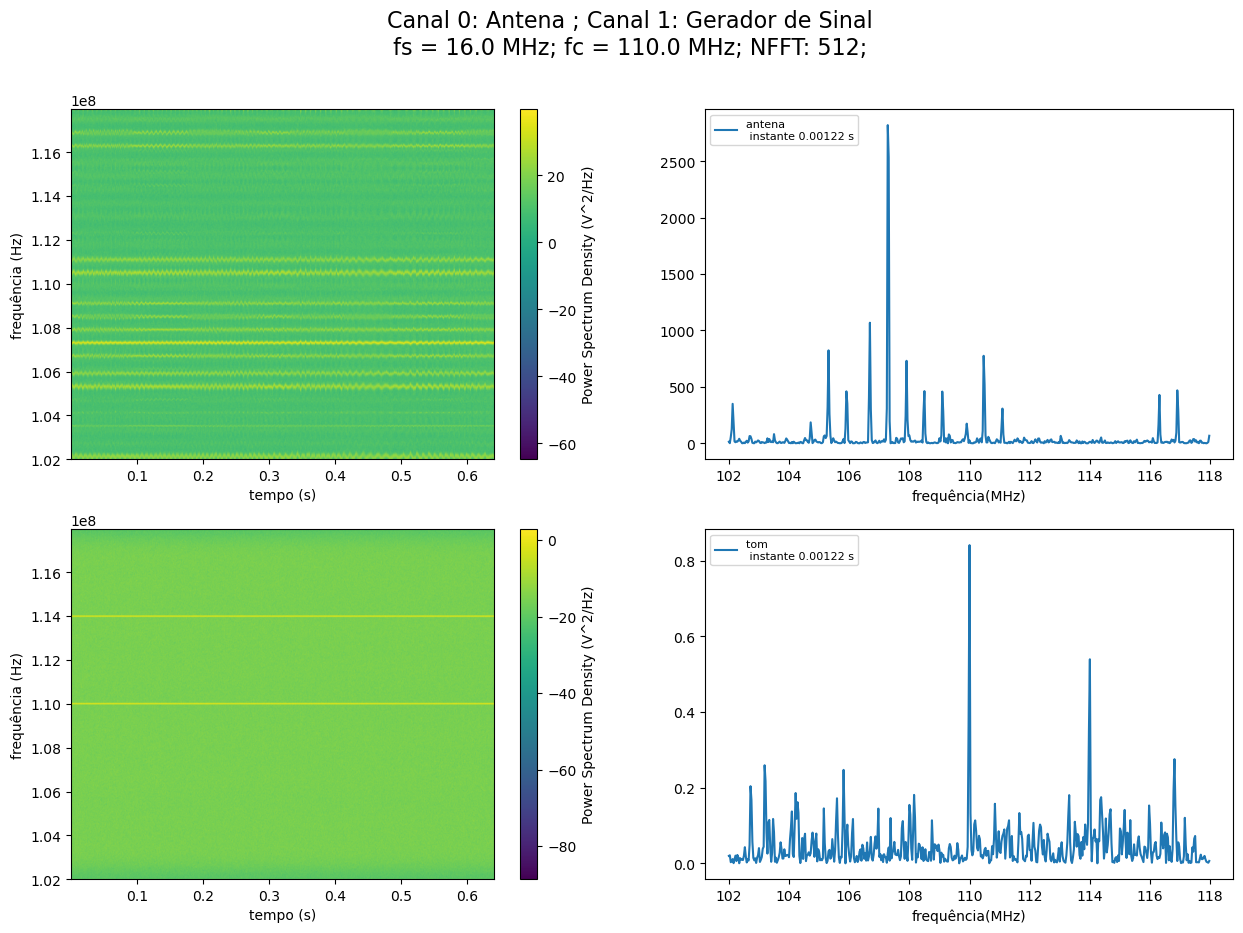

In [50]:
# Organizando os gráficos
fig,ax=plt.subplots(2,2,figsize=(15,10))

myindex=50

spec,freqs,times,im=ax[0,0].specgram(in0_c,Fs=fs1,NFFT=nfft,Fc=fc,sides='twosided')  #waterfall 
ax[0,1].plot(freqs/1e6,spec[:,myindex], label=f'antena \n instante {times[myindex]:.3} s')  # um espectro em um dado instante
ax[0,1].legend(loc='upper left',fontsize=8)

ax[0,0].set_ylabel('frequência (Hz)')
ax[0,0].set_xlabel('tempo (s)')
cbr0=plt.colorbar(im)
cbr0.set_label('Power Spectrum Density (V^2/Hz)')

ax[0,1].set_xlabel('frequência(MHz)')



lspec,lfreqs,ltimes,lim=ax[1,0].specgram(in1_c,Fs=fs1,NFFT=nfft,Fc=fc,sides='twosided')
ax[1,1].plot(lfreqs/1e6,lspec[:,myindex], label=f'tom \n instante {ltimes[myindex]:.3} s')  # um espectro em um dado instante
ax[1,1].legend(loc='upper left',fontsize=8)

ax[1,0].set_ylabel('frequência (Hz)')
ax[1,0].set_xlabel('tempo (s)')
cbr1=plt.colorbar(lim)
cbr1.set_label('Power Spectrum Density (V^2/Hz)')

ax[1,1].set_xlabel('frequência(MHz)')

fig.suptitle(f'Canal 0: Antena ; Canal 1: Gerador de Sinal \n fs = {fs1/1e6} MHz; fc = {fc/1e6} MHz; NFFT: {nfft};  ',fontsize=16);

#fig.savefig('Skarab_2canais_2025Feb15.png')